In [1]:
# 导入所需的库
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 读取图像并转换为灰度图以便于后续处理
img_a = cv2.imread('images/b1.jpg')
img_b = cv2.imread('images/b2.jpg')
gray_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

In [3]:
# 使用SIFT算法检测关键点并计算描述符
sift = cv2.SIFT_create()
kp_a, des_a = sift.detectAndCompute(gray_a, None)
kp_b, des_b = sift.detectAndCompute(gray_b, None)

In [4]:
# 使用FLANN匹配器进行特征点匹配
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_a, des_b, k=2)

In [5]:
# 应用比率测试筛选出优质匹配点
good_matches = []
for m, n in matches:
    # 当第一个匹配点距离小于第二个匹配点距离的0.7倍时，认为是优质匹配
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

In [6]:
# 绘制匹配结果并提取匹配点坐标
matched_keypoints_img = cv2.drawMatches(
    img_a, kp_a,
    img_b, kp_b,
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
# 计算得到匹配点的坐标
src_pts = np.float32([kp_a[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_b[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

In [7]:
# 使用RANSAC算法计算单应性矩阵并进行图像拼接
H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
h_a, w_a = img_a.shape[:2]
h_b, w_b = img_b.shape[:2]
# 计算拼接后图像的尺寸
pts = np.float32([[0, 0], [0, h_b], [w_b, h_b], [w_b, 0]]).reshape(-1, 1, 2)
dst_corners = cv2.perspectiveTransform(pts, H)
all_corners = np.concatenate((dst_corners, np.float32([[0, 0], [w_a, 0], [w_a, h_a], [0, h_a]]).reshape(-1, 1, 2)), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
# 使用透视变换拼接图像
fus_img = cv2.warpPerspective(
    img_b,
    translation_matrix @ H,
    (x_max - x_min, y_max - y_min)
)
fus_img[-y_min:h_a - y_min, -x_min:w_a - x_min] = img_a

Text(0.5, 1.0, 'Fused Image')

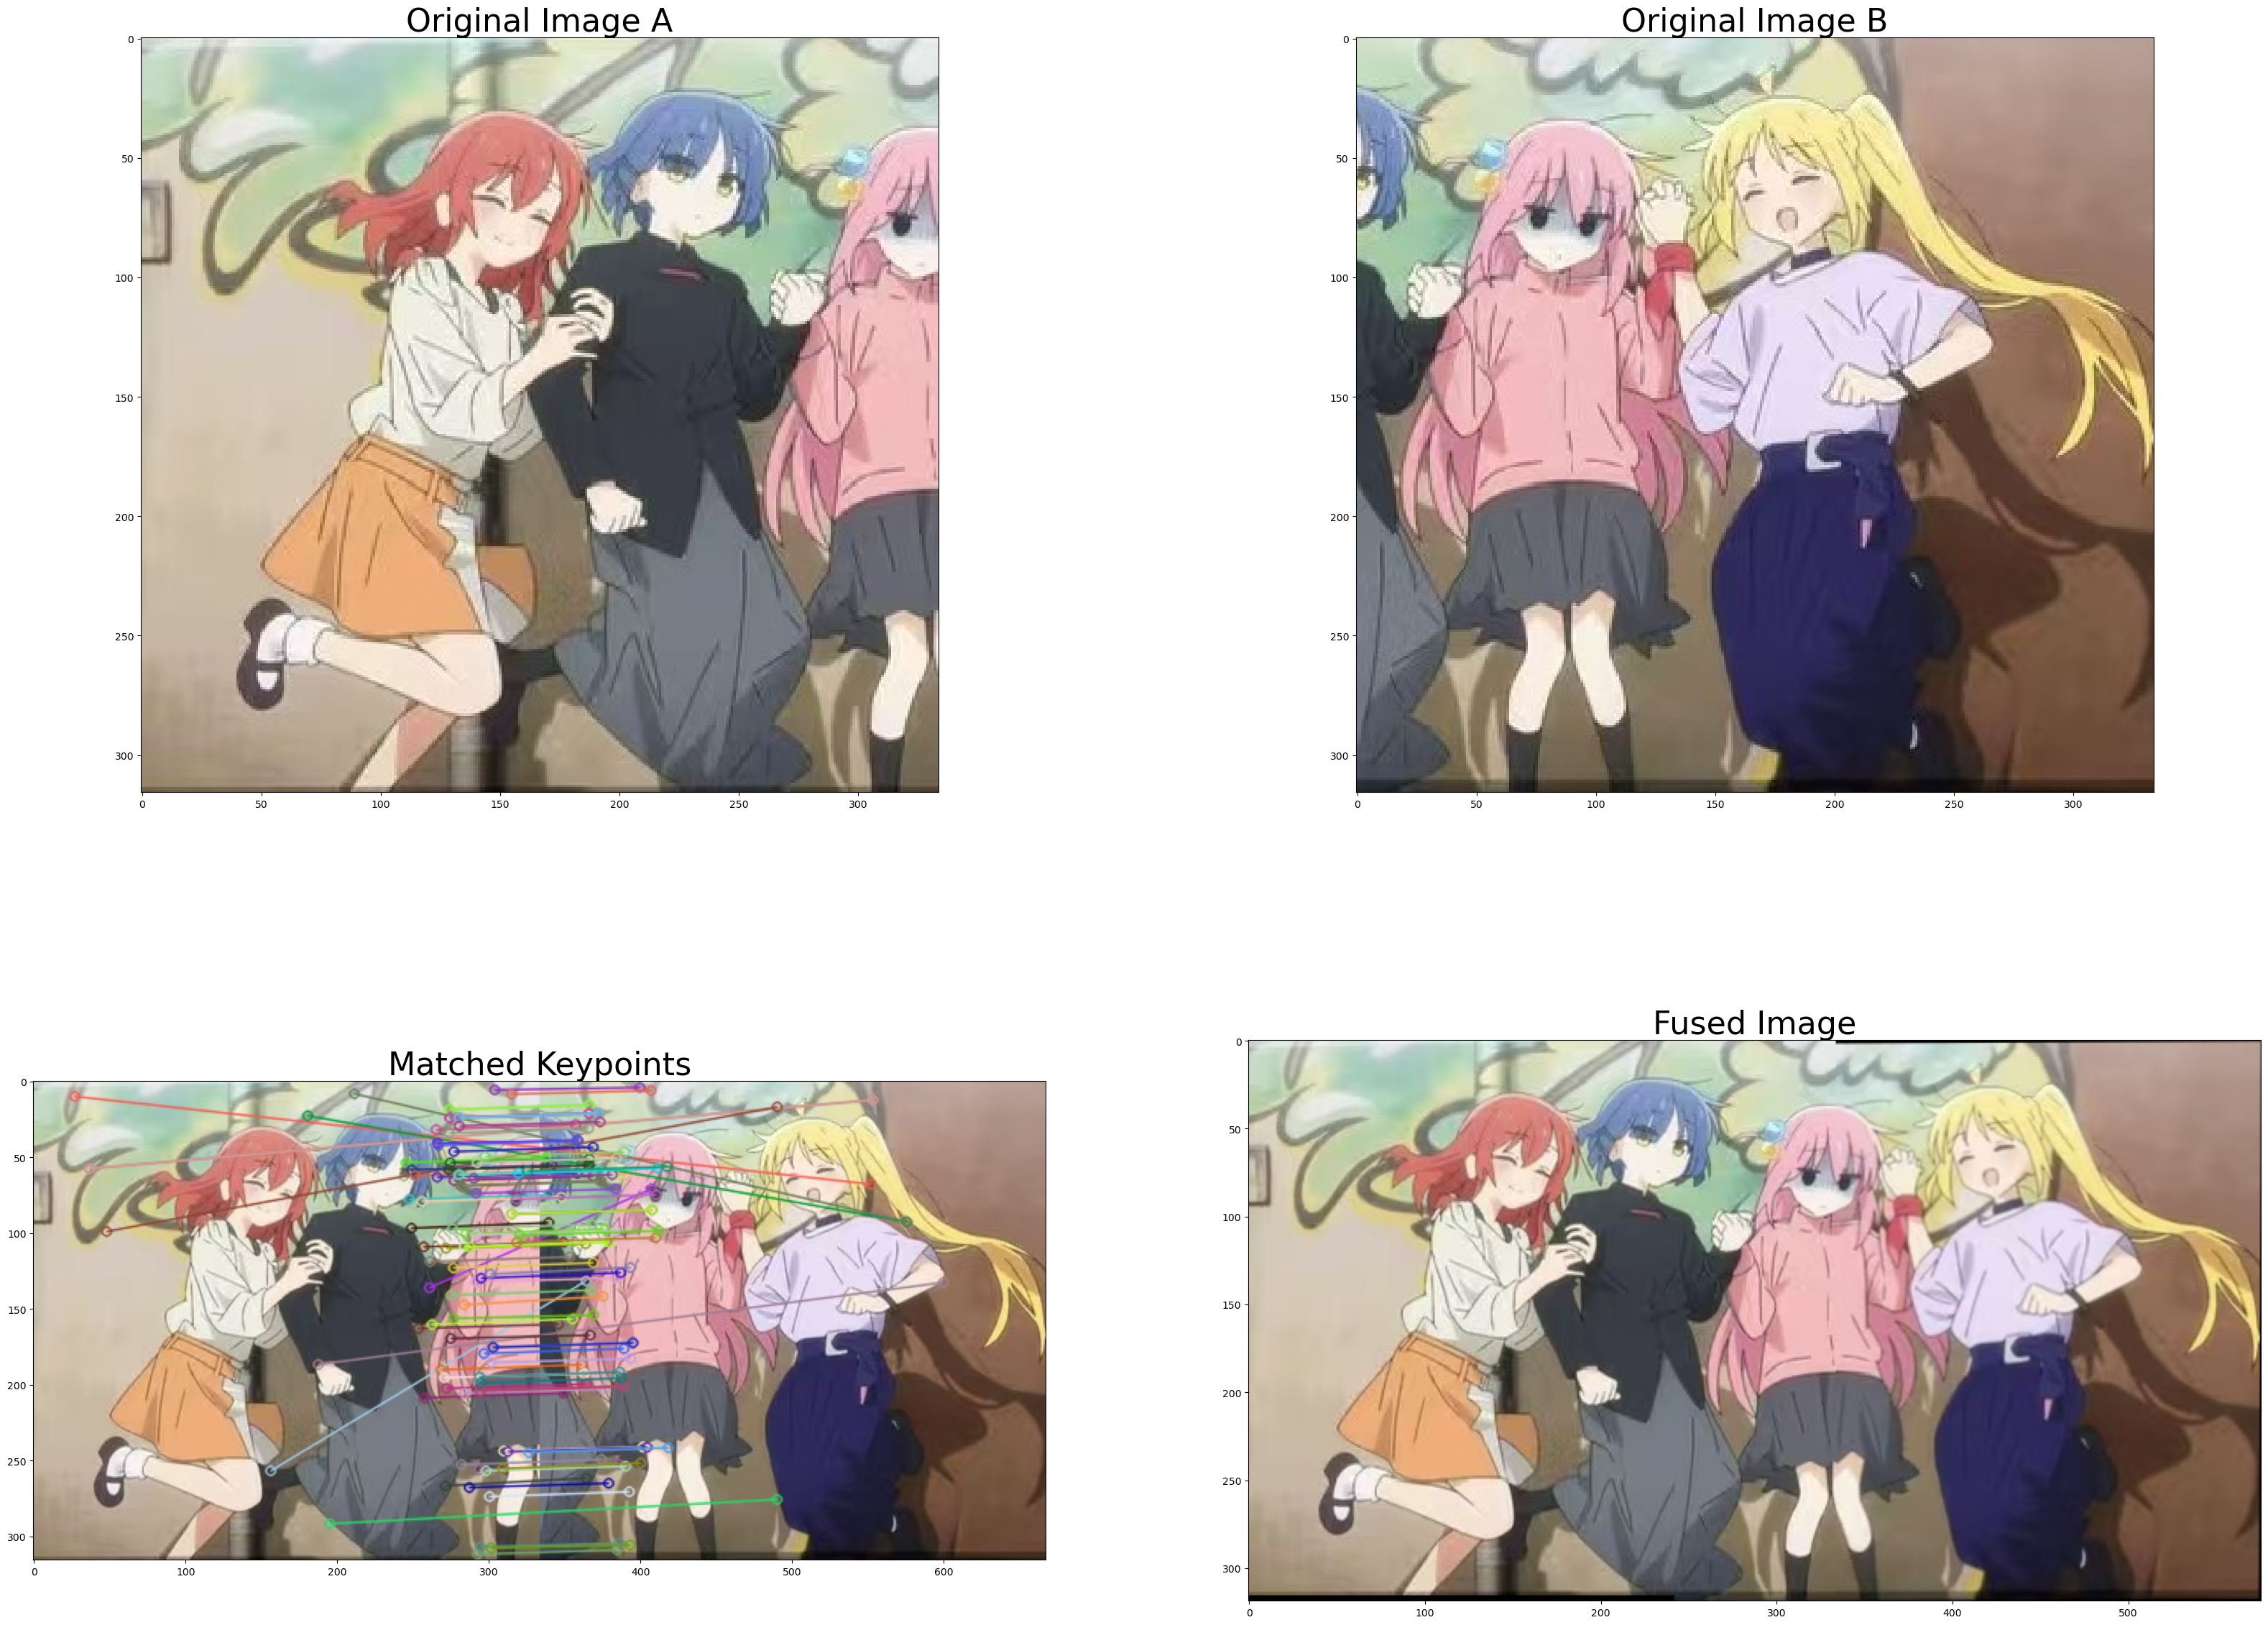

In [10]:
# 绘制结果
plt.figure(figsize=(40,30))
plt.subplot(2,2,1)
# 绘制图像时转换颜色空间以正确显示
plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB))
plt.title('Original Image A', fontsize=32)
plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
plt.title('Original Image B', fontsize=32)
plt.subplot(2,2,3)
# 显示匹配关键点的图像
plt.imshow(cv2.cvtColor(matched_keypoints_img, cv2.COLOR_BGR2RGB))
plt.title('Matched Keypoints', fontsize=32)
plt.subplot(2,2,4)
# 显示拼接后的图像
plt.imshow(cv2.cvtColor(fus_img, cv2.COLOR_BGR2RGB))
plt.title('Fused Image', fontsize=32)